In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
from pathlib import Path 
import numpy as np 



In [175]:
root = "C:/Users/roths/Documents/sims lab/subject" 
folders = ['0','1','3','4','5','6','7','8','9','10'] # skip the incomplete data in folder 2 
seg_path = "segmentation.csv"
out_name = "ch1_dataset_630.pt"

seg = pd.read_csv(seg_path)
print(seg.head())

   folder csv_file_name  sec1  sec2  sec3  sec4  sec5  sec6  sec7  sec8  \
0       0      splg0005   4.0   6.0   8.5  10.5  12.5  14.5  16.5  18.5   
1       0      splg0006   1.0   3.5   6.0   8.0  10.0  12.5  15.0  17.5   
2       0      splg0007   0.5   3.5   6.8   9.5  13.0  15.5  17.5  20.0   
3       0      splg0008   1.0   3.5   5.5   8.0  10.5  13.0  15.5  17.3   
4       0      splg0009   0.3   2.0   4.0   7.0  10.0  13.0  15.5  18.5   

   Unnamed: 10  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  


In [176]:
PATTERN     = [list(map(int, s)) for s in
               ["00100010","10110010","00001110","01100010","11010101"]]
print(PATTERN)
test = "splg0005.csv"
print(int(test[-5])%5)

[[0, 0, 1, 0, 0, 0, 1, 0], [1, 0, 1, 1, 0, 0, 1, 0], [0, 0, 0, 0, 1, 1, 1, 0], [0, 1, 1, 0, 0, 0, 1, 0], [1, 1, 0, 1, 0, 1, 0, 1]]
0


In [177]:
# reading the segmentation csv file to get the paths to the data files we need. 

from pathlib import Path 
import csv 

paths_and_segs = [] 

with open(seg_path,newline = '') as f:
    reader = csv.DictReader(f) 
    for row in reader:
        path= Path(row["folder"])/(row["csv_file_name"]+".csv")
        time_markers = []
        for i in range(1,9):
            time_markers.append(float(row[f"sec{i}"]))
        paths_and_segs.append((path.as_posix(),time_markers))

print(paths_and_segs[:5])
# example output: ('0/splg0005.csv', ['4', '6', '8.5', '10.5', '12.5', '14.5', '16.5', '18.5'])


[('0/splg0005.csv', [4.0, 6.0, 8.5, 10.5, 12.5, 14.5, 16.5, 18.5]), ('0/splg0006.csv', [1.0, 3.5, 6.0, 8.0, 10.0, 12.5, 15.0, 17.5]), ('0/splg0007.csv', [0.5, 3.5, 6.8, 9.5, 13.0, 15.5, 17.5, 20.0]), ('0/splg0008.csv', [1.0, 3.5, 5.5, 8.0, 10.5, 13.0, 15.5, 17.3]), ('0/splg0009.csv', [0.3, 2.0, 4.0, 7.0, 10.0, 13.0, 15.5, 18.5])]


In [178]:
def auto_range(data: np.ndarray):
    range = np.max(data) - np.min(data)
    range_zoom = 0
    while range >= 32 - 1:
        range //= 2
        range_zoom += 1
    #print(f'{range_zoom = } (divide by {round(2 ** range_zoom)})')
    data_max_after_zoom = round(np.max(data) // 2 ** range_zoom)
    #print(f'{data_max_after_zoom = }')
    offset = round(((np.ceil((data_max_after_zoom + 1) / 32) * 32 - data_max_after_zoom) - 1) * 2 ** range_zoom)
    #print(f'{offset = }')
    return (data + offset) // 2 ** range_zoom % 0b100000
    # return (data + offset) // 2 ** range_zoom % 0b11111

In [179]:
def construct_ch1_dataset(paths_and_segs):
    dataset = [] 
    for path, time_markers in paths_and_segs:
        df = pd.read_csv(path, skiprows = 14, names = ["Time","CH1","CH4"]) 

        period = 400e-6 # ADC sampling period
        time_ch_name = "Time"
        adc_ch_name = "CH1"

        digitalized = []
        last_time = df[time_ch_name][0]
        last_volt = df[adc_ch_name][0]
        timestamps = []
        # find the start of the clock cycles
        for timestamp, volt in zip(df[time_ch_name],df[adc_ch_name]):
            if (last_volt < 1 and volt >= 1 or  last_volt > 1 and volt <= 1) and timestamp - last_time > period / 2:
                #print(timestamp, last_volt, volt, timestamp - last_time)
                digitalized.extend([1 if last_volt > 1 else 0] * round((timestamp - last_time) / period))
                last_time = timestamp
                timestamps.append(timestamp)
            last_volt = volt 
    

        #print(digitalized[:100])
        timestamps = np.diff(timestamps)
        timestamps /= period
        err = np.abs(timestamps - np.round(timestamps))
        print(f"finished loading file {path} with conversion errors {err[err > 0.3]}")
        datapoint_len = 16
        
        
        # computing the offset for the 16 bit data frames
        offset = 0
        for offset_try in range(datapoint_len):
            points = np.asarray(digitalized[offset_try:offset_try+(len(digitalized)//datapoint_len-1)*datapoint_len]).reshape(-1, datapoint_len)
            #print(f'{offset_try}: {np.sum(1-points[:,0])} {np.sum(1-points[:,10])} {np.sum(points[:,11])}')
            if np.sum(1-points[:,0]) + np.sum(1-points[:,10]) + np.sum(points[:,11]) == 0:
                #print(f'computed correct {offset_try = }')
                offset = offset_try
                break
        points = np.asarray(digitalized[offset:offset+(len(digitalized)//datapoint_len-2)*datapoint_len]).reshape(-1, datapoint_len)[:,1:10]
        data = np.zeros(len(points))
        for i in range(9): # 9 bits of data inside of the 16 bits received, 
            data += points[:,i] * int(2 ** (8 - i))
        data //= 2
        data = auto_range(data)    # auto range into 5 bits
        gap = 10
        delta = data[gap:] - data[:-gap] # compute a discrete derivative
        times = df["Time"][0] + (offset + np.arange(len(data))*16)*period
        
        
        # cut into 8 chunks and store with its labels. 
        #data_seg_idx = [] 
        times_arr = np.asarray(times)
        segments_arr = np.asarray(time_markers)
        idx = np.searchsorted(times_arr,segments_arr,side = 'right') # find the immediate next index above the 8 segment time thresholds
        #valid = idx < len(times_arr)
        #next_vals = np.where(valid,times_arr[idx],np.nan)
        chunks_data = np.split(data, idx)[1:]
        chunks_time = np.split(times, idx)[1:]
        chunks_delta = np.split(delta, idx)[1:]
        
        
        # match each chunk with its label
        pos_in_pattern = int(path[-5]) % 5 
        csv_pattern = PATTERN[pos_in_pattern]
        for j in range(8):
            if j < len(chunks_data) and chunks_data[j].size > 0:
                dataset.append((chunks_time[j],chunks_data[j],chunks_delta[j],csv_pattern[j]))
            else:
                if j >= len(chunks_data):
                    print()
                # If a chunk is empty or doesn't exist, print a warning
                print(f"⚠️  Warning: Empty data chunk found and skipped for file '{path}' at segment index {j}.")
        
        print(f"finished loading chunks of file {path} with {len(chunks_data)} segments")
    return dataset

In [180]:
ch1_dataset_ls = construct_ch1_dataset(paths_and_segs)

finished loading file 0/splg0005.csv with conversion errors []
finished loading chunks of file 0/splg0005.csv with 8 segments
finished loading file 0/splg0006.csv with conversion errors []
finished loading chunks of file 0/splg0006.csv with 8 segments
finished loading file 0/splg0007.csv with conversion errors []
finished loading chunks of file 0/splg0007.csv with 8 segments
finished loading file 0/splg0008.csv with conversion errors []
finished loading chunks of file 0/splg0008.csv with 8 segments
finished loading file 0/splg0009.csv with conversion errors []
finished loading chunks of file 0/splg0009.csv with 8 segments
finished loading file 0/splg0010.csv with conversion errors []
finished loading chunks of file 0/splg0010.csv with 8 segments
finished loading file 0/splg0011.csv with conversion errors []
finished loading chunks of file 0/splg0011.csv with 8 segments
finished loading file 0/splg0012.csv with conversion errors []
finished loading chunks of file 0/splg0012.csv with 8 s

In [181]:
# save the dataset as a tensor inside a .pt file
import torch
print(type(ch1_dataset_ls))
# ch1_dataset_tensor = torch.tensor(ch1_dataset_ls, dtype=torch.float32)
torch.save(ch1_dataset_ls,out_name)
print(f"saved dataset to {out_name}")

<class 'list'>
saved dataset to ch1_dataset_630.pt


In [182]:
print(len(ch1_dataset_ls))
num_chunks = len(ch1_dataset_ls)
print(ch1_dataset_ls[0])

3240
(array([4.0048, 4.0112, 4.0176, 4.024 , 4.0304, 4.0368, 4.0432, 4.0496,
       4.056 , 4.0624, 4.0688, 4.0752, 4.0816, 4.088 , 4.0944, 4.1008,
       4.1072, 4.1136, 4.12  , 4.1264, 4.1328, 4.1392, 4.1456, 4.152 ,
       4.1584, 4.1648, 4.1712, 4.1776, 4.184 , 4.1904, 4.1968, 4.2032,
       4.2096, 4.216 , 4.2224, 4.2288, 4.2352, 4.2416, 4.248 , 4.2544,
       4.2608, 4.2672, 4.2736, 4.28  , 4.2864, 4.2928, 4.2992, 4.3056,
       4.312 , 4.3184, 4.3248, 4.3312, 4.3376, 4.344 , 4.3504, 4.3568,
       4.3632, 4.3696, 4.376 , 4.3824, 4.3888, 4.3952, 4.4016, 4.408 ,
       4.4144, 4.4208, 4.4272, 4.4336, 4.44  , 4.4464, 4.4528, 4.4592,
       4.4656, 4.472 , 4.4784, 4.4848, 4.4912, 4.4976, 4.504 , 4.5104,
       4.5168, 4.5232, 4.5296, 4.536 , 4.5424, 4.5488, 4.5552, 4.5616,
       4.568 , 4.5744, 4.5808, 4.5872, 4.5936, 4.6   , 4.6064, 4.6128,
       4.6192, 4.6256, 4.632 , 4.6384, 4.6448, 4.6512, 4.6576, 4.664 ,
       4.6704, 4.6768, 4.6832, 4.6896, 4.696 , 4.7024, 4.7088, 4.7152,


### Dataset evaluation split and Recombine. 
Time, waveform, derivative, label. 

In [222]:
train_set = ch1_dataset_ls[:2520] # all files except folder 8,9,10
test_set = ch1_dataset_ls[2520:] 
print(len(test_set))


720


In [231]:
import random  #0.0064
random.shuffle(train_set)

base = 0 
reconstructed_train_set = []
# build training set
while base < len(train_set):
    reconstructed_waveform = []
    reconstructed_derivative = []
    reconstructed_label = ''
    for i in range(8):
        normalized = np.asarray(train_set[base + i][1]) - train_set[base + i][1][-1]
        reconstructed_waveform.extend(normalized.tolist())
        reconstructed_derivative.extend(train_set[base + i][2])
        reconstructed_label += str(train_set[base + i][3])
    reconstructed_derivative.extend([0,0,0,0,0,0,0,0,0,0]) # zero pad the derivative to match the waveform length
    reconstructed_time = np.linspace(0,len(reconstructed_waveform)*0.0064,len(reconstructed_waveform)).tolist()
    reconstructed_train_set.append((reconstructed_time, reconstructed_waveform, reconstructed_derivative,reconstructed_label))
    base += 8

print(f"reconstructed {len(reconstructed_train_set)} training chunks from {len(train_set)} shuffled chunks")




reconstructed 315 training chunks from 2520 shuffled chunks


In [234]:
# build test set 
reconstructed_test_set = []
base = 0
while base < len(test_set):
    reconstructed_waveform = []
    reconstructed_derivative = []
    reconstructed_label = ''
    for i in range(8):
        normalized = np.asarray(test_set[base + i][1]) - test_set[base + i][1][-1]
        reconstructed_waveform.extend(normalized.tolist())
        reconstructed_derivative.extend(test_set[base + i][2])
        reconstructed_label += str(test_set[base + i][3])
    reconstructed_derivative.extend([0,0,0,0,0,0,0,0,0,0]) # zero pad the derivative to match the waveform length
    reconstructed_time = np.linspace(0,len(reconstructed_waveform)*0.0064,len(reconstructed_waveform)).tolist()
    reconstructed_test_set.append((reconstructed_time, reconstructed_waveform, reconstructed_derivative,reconstructed_label))
    base += 8
print(f"reconstructed {len(reconstructed_test_set)} test chunks from {len(test_set)} chunks")

reconstructed 90 test chunks from 720 chunks


In [235]:
torch.save(reconstructed_train_set, "train_set.pt")
torch.save(reconstructed_test_set,"test_set.pt")
print("checkpoints saved. ")

checkpoints saved. 


In [236]:
reconstructed_test_set_shuffled = [] 
base = 0
test_set_shuffled = test_set.copy()
random.shuffle(test_set_shuffled)
while base < len(test_set_shuffled):
    reconstructed_waveform = []
    reconstructed_derivative = []
    reconstructed_label = ''
    for i in range(8):
        normalized = np.asarray(test_set_shuffled[base + i][1]) - test_set_shuffled[base + i][1][-1]
        reconstructed_waveform.extend(normalized.tolist())
        reconstructed_derivative.extend(test_set_shuffled[base + i][2])
        reconstructed_label += str(test_set_shuffled[base + i][3])
    reconstructed_derivative.extend([0,0,0,0,0,0,0,0,0,0]) # zero pad the derivative to match the waveform length
    reconstructed_time = np.linspace(0,len(reconstructed_waveform)*0.0064,len(reconstructed_waveform)).tolist()
    reconstructed_test_set_shuffled.append((reconstructed_time, reconstructed_waveform, reconstructed_derivative,reconstructed_label))
    base += 8
print(f"reconstructed {len(reconstructed_test_set)} test chunks from {len(test_set)} shuffled chunks")

reconstructed 90 test chunks from 720 shuffled chunks


In [237]:
torch.save(reconstructed_test_set_shuffled, "test_set_shuffled.pt")

### Loading the pt files and checking the dataset

In [238]:
dataset = torch.load("train_set.pt",weights_only = False)



<class 'list'>
10110010


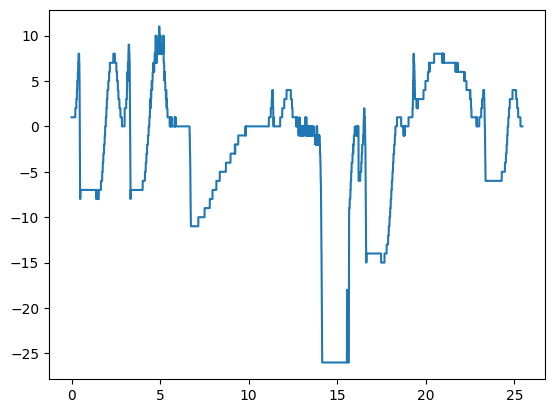

In [239]:
print(type(dataset))
plt.plot(dataset[0][0],dataset[0][1])
print(dataset[0][3])